# Calculation of association between HLA alleles and *Yersinia pestis* status

## Purpose of the notebook
This notebook implements a carrier-based association analysis between one-field HLA alleles and plague case–control status in Early Medieval individuals.  
The workflow:
1. Load an input CSV containing sample identifiers, plague status, and HLA genotypes.  
2. Convert multi-field HLA alleles to one-field resolution.  
3. Perform per-allele Fisher’s exact tests with Haldane–Anscombe correction for odds ratios and 95% confidence intervals.  
4. Apply Benjamini–Hochberg FDR correction across alleles.  
5. Compute a locus-level omnibus chi-square statistic and empirical *P*-value via permutation of case/control labels.  
6. Generate per-locus output tables and optional forest plots.

---

## System requirements
- Operating system: Linux (Ubuntu 20.04+), macOS 12+, or Windows 10+  
- Programming language: **Python 3.11**  
- Hardware: standard 64-bit desktop or laptop; ≥ 8 GB RAM recommended

---

## Required Python version & packages
- `pandas` ≥ 2.0  
- `numpy` ≥ 1.26  
- `scipy` ≥ 1.11  
- `statsmodels` ≥ 0.14  
- `matplotlib` ≥ 3.8 (for forest plots)

A `requirements.txt` or `environment.yml` is provided in the repository for reproducible installation.

---

## Expected inputs & outputs

### Input
A CSV file with at minimum:
- `Sample_ID` — unique identifier per individual  
- `Plague status` — `"case"` or `"control"`  
- HLA loci as comma-separated allele strings:  
  `HLA_A`, `HLA_B`, `HLA_C`, `HLA_DRB1`, `HLA_DQA1`, `HLA_DQB1`, `HLA_DPA1`, `HLA_DPB1`  

Note: Only individuals whose `Sample_ID` starts with `"EDI"` are included (modifiable in code).

### Outputs
Per locus:
- `HLA_<locus>_EDI_case_control.csv`  
  Contains allele-level carrier counts, frequencies, odds ratios (Fisher and HA-corrected), 95% CIs, *P*-values, and FDR *q*-values.

Global summary:
- `HLA_omnibus_summary.csv`  
  Contains the chi-square statistic, empirical permutation *P*-value, and number of permutations per locus.

Optional:
- Forest plots for alleles meeting the minimum carrier threshold.

---

## How to run
1. Install dependencies (example using conda):
   ```bash
   conda create -n ema-hla python=3.11
   conda activate ema-hla
   pip install -r requirements.txt
   
   


In [6]:
# HLA association analysis (carrier-based, one-field alleles)
# Requires: pandas, numpy, matplotlib, statsmodels, scipy

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import fisher_exact
from statsmodels.stats.multitest import multipletests
from math import sqrt

# Load your CSV
df = pd.read_csv("HLA_Plague_input.csv")

# Filter only EDI samples
df = df[df["Sample_ID"].str.startswith("EDI")].copy()

# Define binary case/control
df["is_case"] = (df["Plague status"].str.lower()=="case").astype(int)

# List of loci to test
loci = ["HLA_A","HLA_B","HLA_C","HLA_DQA1","HLA_DPA1","HLA_DPB1"]

#Left out because imputation accuracy is too low
#"HLA_DRB1","HLA_DQB1"


In [7]:
# ------------------------------
# Helper functions
# ------------------------------

def to_one_field(allele):
    """Collapse a full HLA allele to one-field resolution (e.g. HLA_B*07)."""
    if pd.isna(allele) or allele == "":
        return None
    if "*" not in allele:
        return allele
    head, rest = allele.split("*", 1)
    fields = rest.split(":")
    return f"{head}*{fields[0]}"

def extract_onefield(cell):
    """Extract unique one-field alleles from a comma-separated allele string."""
    if pd.isna(cell) or cell == "":
        return []
    alleles = [a.strip() for a in str(cell).split(",") if a.strip()]
    return list({to_one_field(a) for a in alleles})

def locus_fisher(df, locus_col, n_perms=5000):
    """Run carrier-based Fisher tests for one locus + omnibus permutation test."""
    presence = {}
    all_alleles = set()
    for i, row in df.iterrows():
        alleles = extract_onefield(row[locus_col])
        presence[row["Sample_ID"]] = alleles
        all_alleles.update(alleles)

    alleles_sorted = sorted(all_alleles)
    mat = pd.DataFrame(0, index=df["Sample_ID"], columns=alleles_sorted, dtype=int)
    for sid, alleles in presence.items():
        for a in alleles:
            mat.loc[sid, a] = 1
    mat["is_case"] = df.set_index("Sample_ID")["is_case"]

    results = []
    n_cases = int(df["is_case"].sum())
    n_ctrls = int(len(df) - n_cases)

    # Per-allele Fisher tests
    for allele in alleles_sorted:
        a = int(mat.loc[mat["is_case"]==1, allele].sum())  # case carriers
        c = int(mat.loc[mat["is_case"]==0, allele].sum())  # control carriers
        b = n_cases - a
        d = n_ctrls - c

        table = np.array([[a, b],[c, d]])
        OR_fisher, p_fisher = fisher_exact(table, alternative="two-sided")

        # Haldane–Anscombe correction
        a2,b2,c2,d2 = a+0.5, b+0.5, c+0.5, d+0.5
        or_ha = (a2*d2)/(b2*c2)
        se = sqrt(1/a2 + 1/b2 + 1/c2 + 1/d2)
        ci_low = np.exp(np.log(or_ha) - 1.96*se)
        ci_high = np.exp(np.log(or_ha) + 1.96*se)

        results.append({
            "Allele": allele.replace("HLA_", ""),
            "Cases_carriers": a,
            "Ctrls_carriers": c,
            "Freq_cases": a/n_cases,
            "Freq_ctrls": c/n_ctrls,
            "OR_Fisher": OR_fisher,
            "OR_HA": or_ha,
            "CI_low": ci_low,
            "CI_high": ci_high,
            "P_Fisher": p_fisher
        })

    res_df = pd.DataFrame(results)
    res_df["Q_FDR"] = multipletests(res_df["P_Fisher"], method="fdr_bh")[1]
    res_df = res_df.sort_values("P_Fisher").reset_index(drop=True)

    # Omnibus permutation test
    tab = np.vstack([
        mat.loc[mat["is_case"]==1, alleles_sorted].sum().values,
        mat.loc[mat["is_case"]==0, alleles_sorted].sum().values
    ])
    exp = tab.sum(axis=0)*tab.sum(axis=1)[:,None]/tab.sum()
    obs_chi2 = ((tab-exp)**2/exp).sum()

    labels = mat["is_case"].values.copy()
    perm_stats = np.zeros(n_perms)
    for i in range(n_perms):
        np.random.shuffle(labels)
        tabp = np.vstack([
            mat.loc[labels==1, alleles_sorted].sum().values,
            mat.loc[labels==0, alleles_sorted].sum().values
        ])
        exp = tabp.sum(axis=0)*tabp.sum(axis=1)[:,None]/tabp.sum()
        chi2p = ((tabp-exp)**2/exp).sum()
        perm_stats[i] = chi2p
    p_emp = (perm_stats >= obs_chi2).mean()

    return res_df, {"Observed_Chi2": obs_chi2, "Empirical_p": p_emp, "Permutations": n_perms}

def forest_plot(res, locus, min_carriers=2):
    """Make a forest plot for alleles with >= min_carriers total and return the figure."""
    plot_df = res[(res["Cases_carriers"] + res["Ctrls_carriers"]) >= min_carriers].copy()
    if plot_df.empty:
        return None

    plot_df = plot_df.sort_values("OR_HA")
    
    fig, ax = plt.subplots(figsize=(6, max(6, len(plot_df) * 0.3)))
    y = range(len(plot_df))
    ax.errorbar(
        plot_df["OR_HA"], y,
        xerr=[plot_df["OR_HA"] - plot_df["CI_low"], plot_df["CI_high"] - plot_df["OR_HA"]],
        fmt='o', color='black', ecolor='gray', capsize=3
    )
    ax.axvline(1, color='red', linestyle='--')
    ax.set_yticks(y)
    ax.set_yticklabels(plot_df["Allele"])
    ax.set_xlabel("Odds ratio (Haldane–Anscombe, 95% CI)")
    ax.set_title(f"{locus} one-field alleles (cases vs controls)")
    plt.tight_layout()
    plt.show()

    return fig

HLA_A: omnibus chi2=9.63, empirical p=0.213


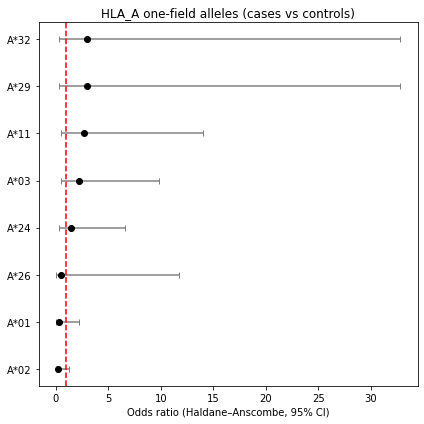

HLA_B: omnibus chi2=10.74, empirical p=0.629


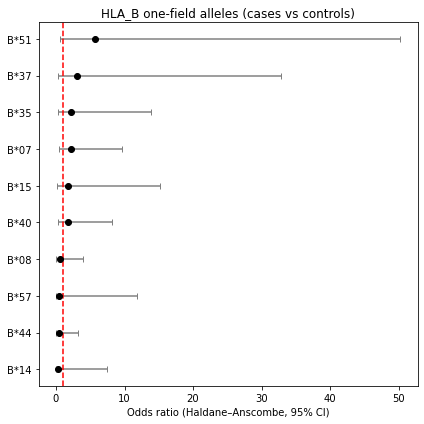

HLA_C: omnibus chi2=11.10, empirical p=0.281


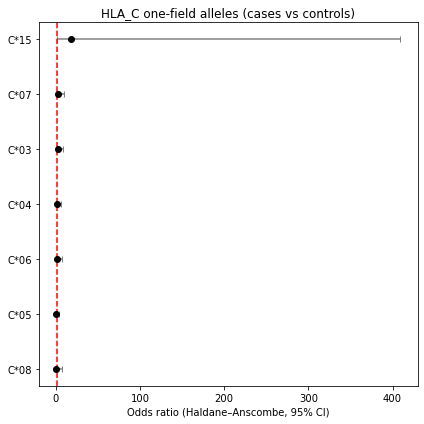

HLA_DQA1: omnibus chi2=3.03, empirical p=0.680


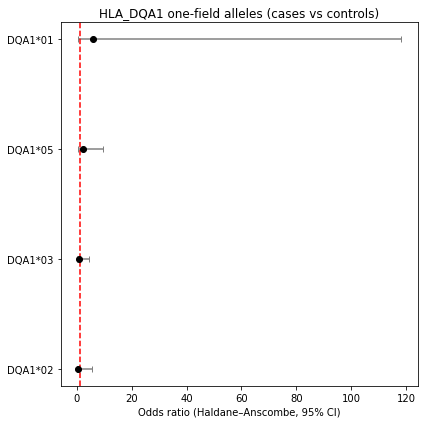

HLA_DPA1: omnibus chi2=0.42, empirical p=0.644


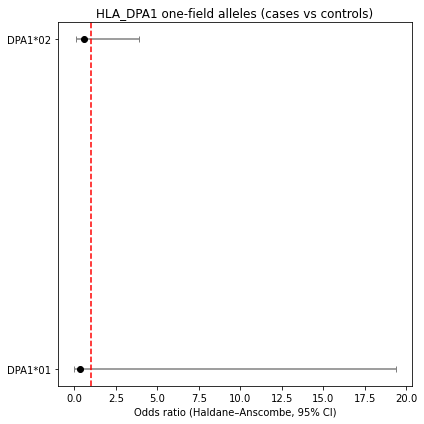

HLA_DPB1: omnibus chi2=4.84, empirical p=0.681


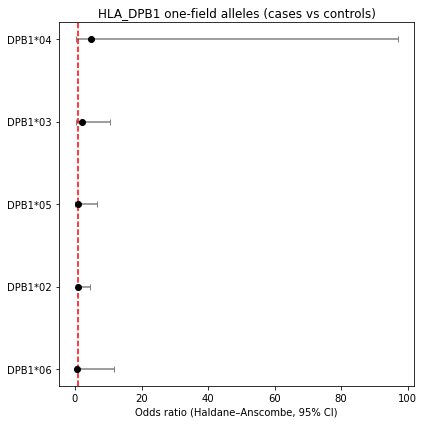


Omnibus results saved to HLA_omnibus_summary.csv


In [9]:
import os

# Ensure plots directory exists
os.makedirs("plots", exist_ok=True)

# Run analyses
results_per_locus = {}
omnibus_per_locus = {}

for locus in loci:
    res, omnibus = locus_fisher(df, locus, n_perms=5000)  # 5k perms
    results_per_locus[locus] = res
    omnibus_per_locus[locus] = omnibus
    
    # Save per-allele CSV
    res.to_csv(f"{locus}_EDI_case_control.csv", index=False)
    
    # Print omnibus result
    print(f"{locus}: omnibus chi2={omnibus['Observed_Chi2']:.2f}, empirical p={omnibus['Empirical_p']:.3f}")
    
    # Forest plot -> save PNG in plots/
    fig = forest_plot(res, locus)
    if fig is not None:
        fig.savefig(f"plots/{locus}_forest_plot.png", dpi=300, bbox_inches="tight")

# Export omnibus results to CSV
omnibus_df = pd.DataFrame([
    {
        "Locus": locus,
        "Observed_Chi2": omnibus_per_locus[locus]["Observed_Chi2"],
        "Empirical_p": omnibus_per_locus[locus]["Empirical_p"],
        "Permutations": omnibus_per_locus[locus]["Permutations"]
    }
    for locus in loci
])
omnibus_df.to_csv("HLA_omnibus_summary.csv", index=False)
print("\nOmnibus results saved to HLA_omnibus_summary.csv")
